In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms
import PIL
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20), 
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset_path = "../Data/train"
full_dataset_train = torchvision.datasets.ImageFolder(dataset_path, transform=train_transforms)
full_dataset_val = torchvision.datasets.ImageFolder(dataset_path, transform=val_transforms)



total_data = len(full_dataset_train)
train_size = int(total_data * 0.85)
val_size = total_data - train_size

indices = torch.randperm(total_data).tolist()
train_set = torch.utils.data.Subset(full_dataset_train, indices[:train_size])
val_set = torch.utils.data.Subset(full_dataset_val, indices[train_size:])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader= torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

train_image, train_label = next(iter(train_loader))
print(f"Total Data: {total_data}")
print(f"Training Set: {len(train_set)} images")
print(f"Validation Set: {len(val_set)} images")
print(f"Batch Shape (Images in 1 Batch): {train_image.shape}")

Total Data: 8000
Training Set: 6800 images
Validation Set: 1200 images
Batch Shape (Images in 1 Batch): torch.Size([32, 3, 224, 224])


In [3]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


train_labels = full_dataset_train.targets
calculated_graphs = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y = train_labels
)

weight_tensor = torch.FloatTensor(calculated_graphs).to(device)

print(f"Class Weights (Penalties): {weight_tensor}")

criterion = nn.CrossEntropyLoss(weight=weight_tensor)


Using device: cuda
Class Weights (Penalties): tensor([ 4.3956,  2.7943,  1.3031, 12.5589,  1.2841,  0.2131, 10.2960],
       device='cuda:0')


In [4]:
num_classes = 7
class SkinCancerModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=3,padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50176,128)
        self.fc2 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        
        x = self.flatten(x)

       
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        
        return x
    
model_v3 = SkinCancerModelV2()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

criterion= nn.CrossEntropyLoss(weight_tensor)
optimizer = optim.Adam(model_v3.parameters(),lr=0.0001)
model_v3.to(device)
model_v3.train()

for epoch in range(15):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_loader:
        image = image.to(device)
        label= label.to(device)
        predict = model_v3(image)
        loss = criterion(predict,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(predict,dim=1)
        batch_correct = (predictions == label).sum().item()
        total_accuary += batch_correct

    mean_loss = total_loss / len(train_loader)

    success_rate = (total_accuary / len(train_loader.dataset)) * 100

    print(f"Epoch {epoch+1} completed. Mean Loss: {total_loss/len(train_loader)},Success Rate: {success_rate}")


Using device: cuda
Epoch 1 completed. Mean Loss: 1.916971872110322,Success Rate: 33.23529411764706
Epoch 2 completed. Mean Loss: 1.7864367721226293,Success Rate: 43.08823529411765
Epoch 3 completed. Mean Loss: 1.7095676369510346,Success Rate: 43.25
Epoch 4 completed. Mean Loss: 1.6652698494458982,Success Rate: 45.51470588235294
Epoch 5 completed. Mean Loss: 1.6158394125145925,Success Rate: 46.44117647058824
Epoch 6 completed. Mean Loss: 1.5659431322639537,Success Rate: 47.279411764705884
Epoch 7 completed. Mean Loss: 1.5487018627739848,Success Rate: 49.10294117647059
Epoch 8 completed. Mean Loss: 1.4929233940554336,Success Rate: 49.35294117647059
Epoch 9 completed. Mean Loss: 1.5039496567327653,Success Rate: 49.5
Epoch 10 completed. Mean Loss: 1.477084994595935,Success Rate: 51.455882352941174
Epoch 11 completed. Mean Loss: 1.4270918260157948,Success Rate: 51.3235294117647
Epoch 12 completed. Mean Loss: 1.4071116738476104,Success Rate: 50.882352941176464
Epoch 13 completed. Mean Loss: 

🎉 Test Result | Mean Loss: 0.9495 | Success Rate: %58.67


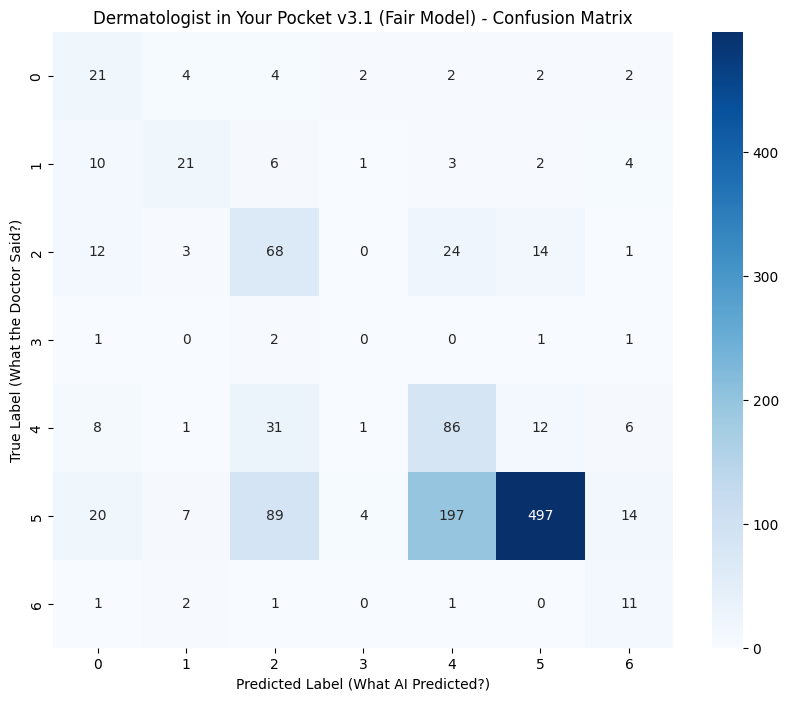

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model_v3.eval()
model_v3 =model_v3.to(device)
criterion= nn.CrossEntropyLoss()
gercek_etiketler = []
model_predictions = []
 
with torch.no_grad():

    total_loss = 0
    total_accuary = 0

    for image ,label in val_loader:
        image , label = image.to(device),label.to(device)
        predict = model_v3(image)
        loss = criterion(predict,label)

        total_loss += loss.item()

        predictions = torch.argmax(predict,dim=1)

        batch_correct = (predictions == label).sum().item()
        total_accuary += batch_correct

        model_predictions.extend(predictions.cpu().numpy())
        gercek_etiketler.extend(label.cpu().numpy())

    mean_loss = total_loss / len(val_loader)

    success_rate = (total_accuary / len(val_loader.dataset)) * 100

    print(f"🎉 Test Result | Mean Loss: {mean_loss:.4f} | Success Rate: %{success_rate:.2f}")




cm = confusion_matrix(gercek_etiketler, model_predictions)


plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
plt.xlabel('Predicted Label (What AI Predicted?)')
plt.ylabel('True Label (What the Doctor Said?)')
plt.title('Dermatologist in Your Pocket v3.1 (Fair Model) - Confusion Matrix')
plt.show()
    
